This notebook computes steady state NOE values for CypA WT and D66A from MD trajectories initiated from distinct macrostates of a 5-state MSM describing 70s and 100s loop dynamics. 

The approach followed is to:

1) Compute autocorrelation functions Cint(t)for bond-vectors N-H after aligning all MD snapshots in a trajectory to a common frame of a reference. 
2) Generate an ACF that combines global tumbling time Ctumble(t) with Cint(t) values using experimentally derived tumbling time values for CypA WT and D66A. This resolves issues with the MD tumbling time between faster than the experimental tumbling time by a factor of ca. x3-4.
3) Use a methodology inspired by Robustelli et al. to remove the effect of numerical errors in the long-tail behavior of Cglob(t)   Robustelli et al. JCTC 2013, 9(11), 5190-5200. Compute the Fourier transform of Cglob(t) to generate J(w) profiles for each N-H vector. 
4) Use Solomon equations to compute ss NOE values from the J(w) profiles assuming a 600 MHz magnet.
5) Weight the NOE values of each nuclei according to the MSM populations of the macrostates
6) Compare the resulting NOE plots with experimental measurements

1) The ACF were computed with Gromacs 5.1.4 using the following commands
1.1
module load gromacs/5.1.4
module load fftw/3.3.4
1.2 - Create an ndx file to extract all backbone NH bonds
gmx make_ndx -f x-ray/cypa_st0.md_01.tpr -o nh.ndx
a N | a H
del 0-17
q
1.3 - Manually delete N-terminal and PRO N atoms in ndx file
(residues 1,4,16,30,58,95,105)
1.4 - Fix timestamp issues
gmx trjconv -f wt_cypa/cypa.cattraj.xtc -o cypa.xray.dry.long.xtc -t0 0 -timestep 5.0
1.5 - Remove rotations and translations
gmx trjconv -f ../xray-dry-notaligned/cypa.xray.dry.long.xtc -s ../cypa.dry.gro -fit rot+trans -o cypa.xray.dry.long.aligned.xtc
echo 4 0
(to align against backbone atoms and output everything)
1.6 - Generate ACFs using lag times up to 50 ns
Do it 5 times, on blocks of 500 ns (-b/-e keywords) so can do SEM estimates
gmx rotacf -d -n ../nh.ndx -P 2 -noaver -s ../wt_cypa/cypa.dry.tpr -f cypa.xray.dry.long.aligned.xtc -acflen 10000 -b 0 -e 500000


2) This notebook starts assuming all ACF files have been produced using the above procedure

In [1]:
import numpy as np
import sys,os
import argparse
import scipy
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from scipy.fftpack import fft
from math import log,log10
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Fitting A exp(-b x)
def func(x, a, b):
    return a*np.exp(-b*x)

def loadACFS(inputfile):
    stream = open(inputfile,'r')
    buffer = stream.readlines()
    stream.close()
    idx = 0
    acfs = {}
    acfs[0] = []
    for line in buffer:
        if ( line.startswith("#") or
             line.startswith("@") ):
            continue
        if line.startswith("&"):
            idx += 1
            acfs[idx] = []
            continue
        elems = line.split()
        val = float(elems[1])
        acfs[idx].append(val)
    del acfs[idx]

    return acfs

# WT

3) We load the raw MD ACFs and multiply with tumbling time. This differs from Robustelli et al. that also uses a smoothing protocol for intermediate C(t) values. Robustelli et al. JCTC 2013, 9(11), 5190-5200

In [76]:
#For WT
WTred_acfs = "/mnt/vmshared/cyp-nmr/S2andJW/paper_version/WT/ACFs/red/rotacf-100ns-0000to2500ns.xvg"
WTorange_acfs = "/mnt/vmshared/cyp-nmr/S2andJW/paper_version/WT/ACFs/orange/rotacf-100ns-0000to2500ns.xvg"
WTmagenta_acfs = "/mnt/vmshared/cyp-nmr/S2andJW/paper_version/WT/ACFs/magenta/rotacf-100ns-0000to2500ns.xvg"
# Output folders
WTred_out = "/mnt/vmshared/cyp-nmr/S2andJW/paper_version/WT/JW/red/"
WTorange_out = "/mnt/vmshared/cyp-nmr/S2andJW/paper_version/WT/JW/orange/"
WTmagenta_out = "/mnt/vmshared/cyp-nmr/S2andJW/paper_version/WT/JW/magenta/"
#Experimental data
WT_NOE_exp = "/mnt/vmshared/cyp-nmr/S2andJW/paper_version/WT/wt_600_hetnoe.dat"

In [4]:
for folder in [WTred_out, WTorange_out, WTmagenta_out]: 
    cmd = "rm -rf %s ; mkdir -p %s" % (folder,folder)
    #print (cmd)
    os.system(cmd)

In [5]:
#Processing WTred
rawACFS_WTred = loadACFS(WTred_acfs)
rawACFS_WTorange = loadACFS(WTorange_acfs)
rawACFS_WTmagenta = loadACFS(WTmagenta_acfs)
out_paths = [WTred_out, WTorange_out, WTmagenta_out]
rawACFS_WT  = [rawACFS_WTred ,rawACFS_WTorange, rawACFS_WTmagenta  ]

In [6]:
observedACFs = []
JWs = []
for z in range(0,3):
    rawACFS = rawACFS_WT[z]
    #For each ACF
    TC = 8200.0 # in ps Exp tumbling time found by Arun in the literature
    #TC = 5000.0 # in ps
    region2max = 0.3
    region2min = 0.05
    timestep = 5.0 # in ps
    xinf = 65536 # gives 327680 ps
    for ACFidx in rawACFS.keys():
        ACF = np.array(rawACFS[ACFidx])
        #print (ACF)
        observedACF = np.array(np.zeros(xinf))
        #for x in range(0,len(ACF)):
        for x in range(0,xinf):
            time = timestep*x
            globalACF = func(time,1.0,1/TC)
            #Internal C(t) only runs up to 100 ns
            if (time < 100000):
                observedACF[x] = ACF[x]*globalACF
            else:
                observedACF[x] = ACF[-1]*globalACF
        observedACFs.append(observedACF)
        #print (observedACF)
        stream = open('%s/observedACF-%s.dat' % (out_paths[z],ACFidx),'w')
        for x in range(0,len(observedACF)):
            t = x*timestep
            val = observedACF[x]
            stream.write("%8.2f %e\n" % (t,val))
        stream.close()
        # FFT
        # see https://docs.scipy.org/doc/scipy-0.18.1/reference/tutorial/fftpack.html
        J = fft(np.array(observedACF))
        # Scale result
        # But Robustelli et al. have http://pubs.acs.org/doi/full/10.1021/ct400654r
        # J(w) = (2/5) Re [ \int C(t) exp (-iwt) dt ]
        scale = 2/5.
        Jscl = []
        for x in range(0,len(J)):
            Jx = J[x]
            Jsclx = scale*Jx
            Jscl.append(Jsclx)
        Jscl = np.array(Jscl)
        JWs.append(Jscl)
        stream = open('%s/spectraldensity-%s.dat' % (out_paths[z],ACFidx),'w')
        N = len(Jscl)
        T = 1/timestep
        ws = np.linspace(0.0,0.1/(2.0*T),N/2)
        # Arbitrarily write J(0) at -6 on the x-axis
        stream.write("-6 %e\n" % (Jscl[0]))
        for x in range(1,int(len(Jscl)/2)):
            # must check what w is exactly
            w = log10(ws[x])
            val = Jscl[x]
            #print (w,val)
            stream.write("%e %e\n" % (w,val))
         #import pdb ; pdb.set_trace()
        stream.close()

/home/julien/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/julien/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
/home/julien/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part


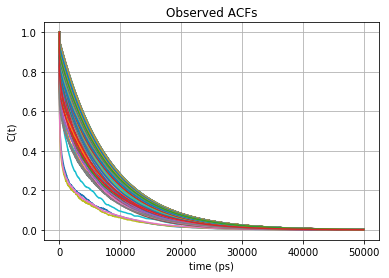

In [7]:
#Verify all mixed ACFs are well behaved
fig, ax = plt.subplots()
t = []
for x in range(0,len(observedACF)):
    t.append(x*timestep)
# Plot only first 50 ns because it's all essentially decayed after that
for s in observedACFs:
    ax.plot(t[0:10000],s[0:10000])

ax.set(xlabel='time (ps)', ylabel='C(t)',
       title='Observed ACFs')
ax.grid()

#fig.savefig("test.png")
plt.show()

/home/julien/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


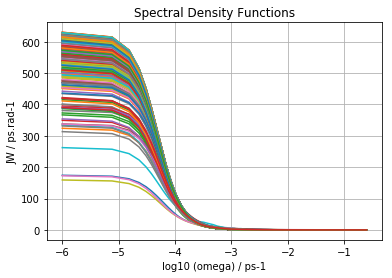

In [8]:
#Verify all JWs look ok
t = [-6]
ws = np.linspace(0.0,0.1/(2.0*T),N/2)
for x in range(1,int(len(Jscl)/2)):
    # must check what w is exactly
    w = log10(ws[x])
    t.append(w)

reals = []
y = 0 
for JW in JWs:
    reals.append([])
    for x in range(0,int(len(JW)/2)):
        reals[y].append(JW[x].real)
    y += 1
fig, ax = plt.subplots()
for JW in reals:
    ax.plot(t,JW)
#ax.plot(t,reals[0])
ax.set(xlabel='log10 (omega) / ps-1', ylabel='JW / ps.rad-1', title='Spectral Density Functions')
ax.grid()
#fig.savefig("test.png")
plt.show()


4) Now we use the J(w) functions to compute NOE values for each N-H pair in each macrostate.

In [16]:
# On a 600 MHz spectrometer
# wS = 600 MHz --> log10(600E6*1E-12) = -3.22
# wI = 60 MHz --> log10(600E-6*1E-12) = -4.30
# R1 = (d00/4.0) * ( J_wISminus + 3*J_wI + 6*J_wISplus )
# R2 = (d00/8.0) * ( 4 * J_0 + J_wISminus + 3*J_wI + 6*J_wS + 6*J_wISplus )
# HetNOE = 1 + (d00/4.) * (6*J_wISplus-J_wISminus) * (1/R1) * (gammaH/gammaN)
# Plugging in R1 in HetNOE we get
# HetNOE =  1 + ( (6*J_wISplus-J_wISminus) * (gammaH/gammaN) ) /  ( J_wISminus + 3*J_wI + 6*J_wISplus )
freq = 600E6 # 600 MHz
gammaH = 42.577#  MHz.T-1
gammaN = -4.316#  MHz.T-1
wS = log10(freq*1E-12) # -3.22 at 600 MHz, input in ps-1
wI = log10(freq/10.0*1E-12) # -4.30 at 600 Mhz
wISplus = log10((freq+freq/10.0)*1E-12)
wISminus = log10((freq-freq/10.0)*1E-12)

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

def interpolate(wvals,freq,Jvals):
    nearest_freq = find_nearest(wvals,freq)
    nearest_freq_minone = nearest_freq - 1
    nearest_freq_plusone = nearest_freq + 1
    if (   abs( wvals[nearest_freq_minone] - wI)
           < abs( wvals[nearest_freq_plusone] - wI) ):
        next_nearest_freq = nearest_freq_minone
    else:
        next_nearest_freq = nearest_freq_plusone
    # print (freq,wvals[nearest_freq],wvals[next_nearest_freq])
    if wvals[nearest_freq] < wvals[next_nearest_freq]:
        lower = nearest_freq
        upper = next_nearest_freq
    else:
        lower = next_nearest_freq
        upper = nearest_freq

    # print (lower,upper)
    d = (freq-wvals[lower])/(wvals[upper]-wvals[lower])
    # print (d)
    J_freq = d*Jvals[upper]+(1-d)*Jvals[lower]
    # print (J_freq)
    return J_freq

In [28]:
#Read in JWs
results = {}
for z in range(0,3):
    results[z] = {}
    datapath = out_paths[z]
    files = os.listdir(datapath)
    for f in files:
        if f.startswith("spectraldensity"):
            base, idx = f.split("-")
            idx = idx.rstrip(".dat")
            idx = int(idx)
            #print (idx,f)
            stream = open(os.path.join(datapath,f),'r')
            buffer = stream.readlines()
            stream.close()
            warray = []
            Jarray = []
            for line in buffer:
                w, J = line.split()
                w = float(w)
                J = float(J)
                warray.append(w)
                Jarray.append(J)

            wvals = np.array(warray)
            Jvals = np.array(Jarray)
    
            J_0 = Jvals[0]
            J_wI = interpolate(wvals,wI,Jvals)
            J_wS = interpolate(wvals,wS,Jvals)
            J_wISplus = interpolate(wvals,wISplus,Jvals)
            J_wISminus = interpolate(wvals,wISminus,Jvals)
    
            HetNOE = 1 + ( (6*J_wISplus-J_wISminus) * (gammaH/gammaN) ) / ( J_wISminus + 3*J_wI + 6*J_wISplus )
            #print (idx,HetNOE)
            results[z][idx] = HetNOE

In [34]:
#Now let's fix the idx numbering to account for the excluded N-terminal residue and Pro residues

In [55]:
map_indices = [1,4,16,30,58,95,105]
shifted = {}
for z in range(0,3):
    shifted[z] = {}
    keys = list(results[z].keys())
    keys.sort()
    #print (keys)
    for k in keys:
        id = int(k)
        offset = 0
        for value in map_indices:
            #print (id)
            if (id >= (value-1)):
                offset += 1
        id = id + offset
        shifted[z][id] = results[z][k]
#print (shifted[0])
#print (shifted[1])
#print (offset)

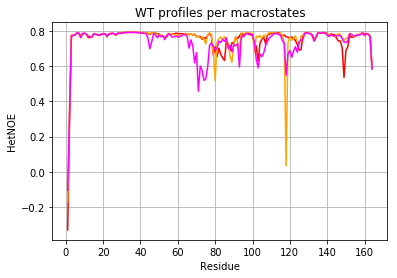

In [59]:
#Plot the 3 long trajs
fig, ax = plt.subplots()

x = list(shifted[0].keys())
x.sort()
for z in range(0,3):
    HetNOE = []
    for k in x:
        HetNOE.append(shifted[z][k])
    if z == 0:
        ax.plot(x,HetNOE, 'r')
    elif z == 1:
        ax.plot(x,HetNOE,'orange')
    else:
        ax.plot(x,HetNOE,'magenta')

ax.set(xlabel='Residue', ylabel='HetNOE',
       title='WT profiles per macrostates')
ax.grid()

#fig.savefig("test.png")
plt.show()

In [74]:
# Now average profiles according to MSM populations
#red      0.28
#orange   0.41
#magenta  0.18/0.31 (if absorbing blue)
populations = [0.28,0.41,0.31]
avgHetNOE = {}
residues = list(shifted[0].keys())
residues.sort()
for res in residues:
    val = 0.0
    for z in range(0,3):
        val += populations[z]*shifted[z][res]
    avgHetNOE[res] = val
#print (avgHetNOE)



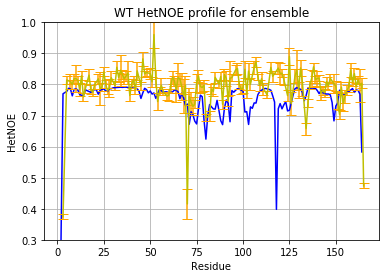

In [107]:
#Plot the weighted ensemble and compare with the experimental data

stream = open(WT_NOE_exp,'r')
buffer = stream.readlines()
stream.close()
exp_id = []
exp_hetnoe = []
exp_hetnoeerr = []
for line in buffer:
    elems = line.split()
    exp_id.append(int(elems[0]))
    exp_hetnoe.append(float(elems[1]))
    exp_hetnoeerr.append(float(elems[2]))

#print (exp_id)
#sys.exit(-1)

fig, ax = plt.subplots()

x = list(avgHetNOE.keys())
x.sort()
HetNOE = []
for k in x:
    HetNOE.append(avgHetNOE[k])
ax.plot(x,HetNOE, 'b')
#ax.plot(exp_id,exp_hetnoe,yerr=exp_hetnoeerr)
ax.errorbar(exp_id, exp_hetnoe, yerr=exp_hetnoeerr,fmt='y',markersize=8,capsize=5,ecolor='orange')
#ax.errorbar(exp_id, exp_hetnoe, yerr=exp_hetnoeerr,fmt='y', error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2))

ax.set(xlabel='Residue', ylabel='HetNOE',
       title='WT HetNOE profile for ensemble')
ax.grid()

plt.ylim(0.3,1.0)
#fig.savefig("test.png")
plt.show()
    